**Universidade Federal de Campina Grande**
<br/>
**Programa de Pós-Graduação em Ciência da Computação**
<br/>
**Disciplina:** _Aprendizagem de Máquina_
<br/>
**Estudante:** _Ruan Victor Bertoldo Reis de Amorim_

## <center>Classificação de Transformações Sintáticas em Técnicas de Síntese de Programas</center>

# 1. Introdução

<div style=\"text-align: justify\">
Em minha pesquisa de mestrado, eu estou desenvolvendo uma ferramenta interativa que fornece feedback de alto nível para alunos de introdução a programação. O objetivo da ferramenta, chamada de `TraceDiff`, é possibilitar que os estudantes entendam os comportamentos inesperados dos seus códigos comparando-os com versões corrigidas dos mesmos. Dentre as principais funcionalidades do `TraceDiff`, podemos destacar a capacidade de corrigir códigos Python em tempo real e de forma automatizada. Para esta tarefa, o `TraceDiff` utiliza uma técnica de síntese de programas chamada de `Refazer` que é capaz de aprender e aplicar transformações síntáticas de código.
<br/><br/>
Inicialmente, é necessário fornecer para o `Refazer` uma base de dados composta por conjuntos de códigos incorretos e suas respectivas correções. No seguinte exemplo, podemos observar uma possível entrada para nossa técnica de síntese de programas. O primeiro quadro representa um código incorreto, a linha em vermelho indica a localização do erro cometido na implementação. Em seguida, no segundo quadro, podemos observar uma versão corrigida, a linha em azul representa a edição que foi necessário para corrigir o referido código. Uma tupla contento estes dois códigos é dado como entrada para o `Refazer` para que ele aprenda transformações sintáticas que representem tal correção. Dessa forma, o `TraceDiff` pode aplicar essas tranformações sintáticas em submissões futuras de outros alunos.
![title](img/exemplo2.png) ![title](img/exemplo1.png)
<br/><br/>
Para uma única entrada ou exemplo, o `Refazer` pode aprender **centenas de transformações sintáticas** além da que é considerada correta. Isso acontece porque a técnica tenta explorar o maior espaço possível de variações para ambos os códigos. No entanto, algumas das transformações aprendidas estão muito distantes da transformação ideal, portanto, não é interessante mantê-las e nem aplicá-las. Neste trabalho de _Apredizagem de Máquina_, queremos implementar um classificador baseado em **regressão logística** que seja capaz de identificar transformações sintáticas indesejadas. Dessa forma, poderemos utilizar o classificador para eleminar as transformações de efeito negativo, assim, economizando os rescursos computacionais que atualmente são desperdiçados com essas operações.

</div>

# 2. Descrição dos Dados

<div style=\"text-align: justify\">
Os dados são compostos por 1314 transformações sintáticas geradas pelo `Refazer` a partir de edições executadas em três grandes projetos do Github (Roslyn, Entity Framework e NuGet). Dado o nosso conjunto de transformações, nós extraímos 12 features para conduzir este trabalho. Em seguida, a descrição de cada feature.
</div>
- **ConstNode:** _número de constantes no programa._
- **Reference:** _número de referências no programa._
- **_ConcretePattern:_**
- **_AbstractPattern:_**
- **Node:** _número de nós no programa._
- **Pattern:** _número de padrões no programa._
- **ParentOne:** _número de nós com apenas um pai._
- **ParentTwo:** _número de nós com dois pais._
- **ParentThree:** _número de nós com três pais._
- **NodeItself:** _número de nós sem pais._
- **SizeProg:** _número de linhas do programa._ 
- **NumberOp:** _número de operações utilizadas para gerar um programa._
- **Label:** _representa se uma transformação obteve efeito desejável(1) ou indesejável(0)._

# 3. Tratamento dos Dados

<div style=\"text-align: justify\">
Dado a descrição dos dados considerados neste estudo, foi necessário separar as features (X) e os labels (Y) do nosso dataset. Em seguida, dividimos os dados em 90% para treino e 10% para teste utilizando a função `train_test_split` que é fornecida pelo `scikit-learn`. O código Python a seguir realiza as operações descritas.
</div>

In [61]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

data = pd.read_csv("data/ProgStatus.csv")

X = data[['ConstNode','Reference','ConcretePattern', 'AbstractPattern', 'Node', 'Pattern', 'ParentOne', 'ParentTwo', 'ParentThree', 'NodeItself', 'SizeProg', 'NumberOp']]
Y = data[['Label']].values.ravel()

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, Y, train_size=0.9)

# 4. Modelo de Regressão Logística

<div style=\"text-align: justify\">
Nosso objetivo neste trabalho é encontrar um modelo de regressão logística (com regularização) que seja eficaz em classificar transformações sintáticas como positivas (efeito esperado) e negativa (efeito inesperado). Para tal objetivo, nós utilizamos o `scikit-learn` uma biblioteca de aprendizado de máquina de código aberto para a linguagem de programação Python. Ela inclui vários algoritmos de classificação, regressão e agrupamento incluindo máquinas de vetores de suporte, florestas aleatórias, gradient boosting, k-means e DBSCAN, e é projetada para interagir com as bibliotecas Python numéricas e científicas NumPy e SciPy.
</div>

## 4.1 Tunando Hiperparâmetros (Coeficiente de Regularização)

Nesta secção, queremos encontrar o melhor modelo de regressão logística e parâmetro de regularização que correspondam as nossas expectativas. Considerando as convenções do `scikit-learn`, o parâmetro **C** controla a quantidade de regularização do modelo de regressão logistíca. Um grande valor para C resulta em menos regularização. 

Queremos encontrar o melhor C considerando os três aspectos a seguir:
- **Log Loss:** 
> Mede o desempenho de um modelo de classificação onde a entrada de previsão é um valor de probabilidade entre 0 e 1.

- **Acurácia:**
> Métrica de precisão que pode ser aplicada para avaliar predições.

- **GridSearchCV:**
> Uma API Python que executa uma pesquisa exaustiva por valores de parâmetros especificados para um estimador.

In [7]:
c_values = [0.001, 0.005, 0.01, 0.05, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

### 4.1.1 Log Loss com Validação Cruzada

In [62]:
def scoring_loss_cv(model):
    scores_loss= -cross_val_score(model, X_TRAIN, Y_TRAIN, scoring="neg_log_loss", cv = 10)
    return(scores_loss)

In [63]:
cv_logistic_loss = [scoring_loss_cv(LogisticRegression(C = c)).mean() 
            for c in c_values]

Text(0,0.5,'Log Loss')

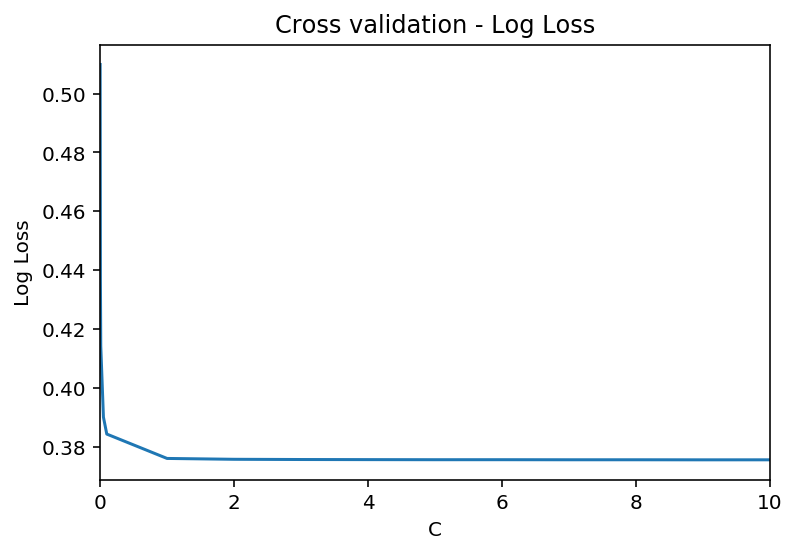

In [64]:
cv_logistic_loss = pd.Series(cv_logistic_loss, index = c_values)
cv_logistic_loss.plot(title = "Cross validation - Log Loss")
plt.xlabel("C")
plt.ylabel("Log Loss")

In [65]:
cv_logistic_loss

0.001     0.509881
0.005     0.436819
0.010     0.414239
0.050     0.390083
0.100     0.384320
1.000     0.376041
2.000     0.375750
3.000     0.375676
4.000     0.375640
5.000     0.375609
6.000     0.375614
7.000     0.375591
8.000     0.375590
9.000     0.375568
10.000    0.375574
dtype: float64

In [66]:
cv_logistic_loss.min()

0.37556791398614081

> _Melhor parâmetro C encontrado:_ **9**

In [89]:
logreg_loss = LogisticRegression(C=9)
model_loss = logreg_loss.fit(X_TRAIN, Y_TRAIN)
model_loss

LogisticRegression(C=9, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### 4.1.2 Accuracy com Validação Cruzada

In [90]:
def scoring_accuracy_cv(model):
    scores_accuracy= cross_val_score(model, X_TRAIN, Y_TRAIN, scoring="accuracy", cv = 10)
    return(scores_accuracy)

In [91]:
cv_logistic_accuracy = [scoring_accuracy_cv(LogisticRegression(C = c)).mean() 
            for c in c_values]

Text(0,0.5,'Accuracy')

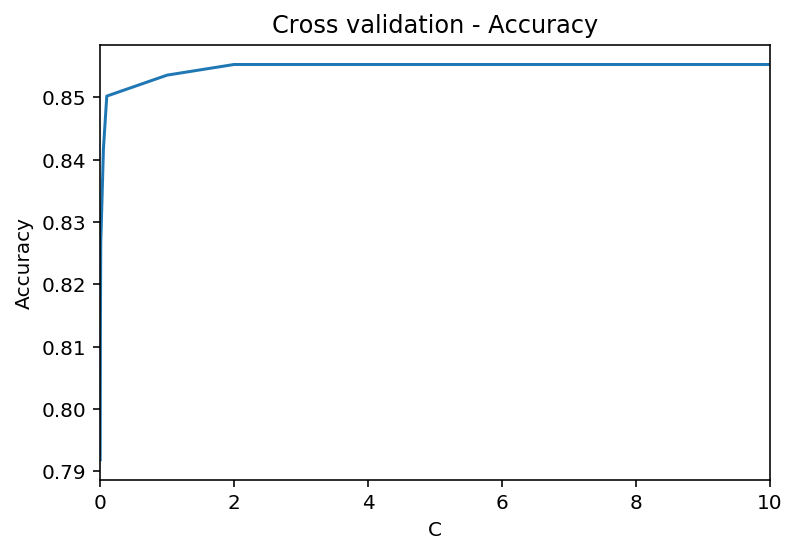

In [92]:
cv_logistic_accuracy = pd.Series(cv_logistic_accuracy, index = c_values)
cv_logistic_accuracy.plot(title = "Cross validation - Accuracy")
plt.xlabel("C")
plt.ylabel("Accuracy")

In [93]:
cv_logistic_accuracy

0.001     0.791841
0.005     0.813905
0.010     0.826553
0.050     0.841708
0.100     0.850169
1.000     0.853530
2.000     0.855240
3.000     0.855240
4.000     0.855240
5.000     0.855240
6.000     0.855240
7.000     0.855240
8.000     0.855240
9.000     0.855240
10.000    0.855240
dtype: float64

In [94]:
cv_logistic_accuracy.max()

0.8552395317101199

> _Melhor parâmetro C encontrado:_ **10**

In [95]:
logreg_accuracy = LogisticRegression(C=10)
model_accuracy = logreg_accuracy.fit(X_TRAIN, Y_TRAIN)
model_accuracy

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### 4.1.3 GridSearchCV

In [97]:
tuned_parameters = {'C': c_values }
model_grid_search = GridSearchCV(LogisticRegression(), tuned_parameters, cv=10)
model_grid_search.fit(X_TRAIN, Y_TRAIN)

model_grid_search.best_estimator_

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

> _Melhor parâmetro C encontrado:_ **2**

## 4.2 Modelo Sem Regularização

In [98]:
model_no_regularization = LogisticRegression()
model_no_regularization.fit(X_TRAIN, Y_TRAIN)
model_no_regularization

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# 5. Resultado

## 5.1 Intercept e Coeficientes

In [99]:
# Modelo por Log Loss
print("Intercept: {0}\n".format(model_loss.intercept_))
print("Coeficientes: \n{0}".format(model_loss.coef_))

Intercept: [ 0.91090175]

Coeficientes: 
[[ 0.93737242 -0.80088996  1.14513792  1.38604293  0.56511262  0.56820033
   1.07359638  1.3698152   0.         -0.15415978 -0.37972728  0.66605   ]]


In [100]:
# Modelo por Acurácia
print("Intercept: {0}\n".format(model_accuracy.intercept_))
print("Coeficientes: \n{0}".format(model_accuracy.coef_))

Intercept: [ 0.90814341]

Coeficientes: 
[[ 0.9375916  -0.80178721  1.14661284  1.3876431   0.56626311  0.56919985
   1.07541767  1.37147499  0.         -0.15391543 -0.38029621  0.66913843]]


In [101]:
# Modelo com GridSearchCV
print("Intercept: {0}\n".format(model_grid_search.best_estimator_.intercept_))
print("Coeficientes: \n{0}".format(model_grid_search.best_estimator_.coef_))

Intercept: [ 0.88698114]

Coeficientes: 
[[ 0.90954315 -0.84866513  1.03449352  1.28242049  0.48291017  0.49101428
   1.05196589  1.32649366  0.         -0.15615177 -0.3359597   0.51928695]]


In [102]:
# Modelo Sem Regularização
print("Intercept: {0}\n".format(model_no_regularization.intercept_))
print("Coeficientes: \n{0}".format(model_no_regularization.coef_))

Intercept: [ 0.852442]

Coeficientes: 
[[ 0.88113472 -0.8910296   0.93120531  1.18569409  0.40691392  0.4185029
   1.02844749  1.28090134  0.         -0.15976434 -0.29493691  0.39316172]]


## 5.2 Dados de Treino

In [103]:
# Modelo por Log Loss
model_loss.score(X_TRAIN, Y_TRAIN)

0.86379018612521152

In [104]:
# Modelo por Acurácia
model_accuracy.score(X_TRAIN, Y_TRAIN)

0.86379018612521152

In [105]:
# Modelo com GridSearchCV
model_grid_search.score(X_TRAIN, Y_TRAIN)

0.85702199661590528

In [106]:
# Modelo Sem Regularização
model_no_regularization.score(X_TRAIN, Y_TRAIN)

0.85617597292724201

## 5.3 Dados de Teste

In [107]:
# Modelo por Log Loss
model_loss.score(X_TEST, Y_TEST)

0.9242424242424242

In [108]:
# Modelo por Acurácia
model_accuracy.score(X_TEST, Y_TEST)

0.9242424242424242

In [109]:
# Modelo com GridSearchCV
model_grid_search.score(X_TEST, Y_TEST)

0.91666666666666663

In [110]:
# Modelo Sem Regularização
model_no_regularization.score(X_TEST, Y_TEST)

0.91666666666666663